In [1]:
from perceptron import QPerceptron
import numpy as np
from utils import train_df, test_df

train_df = train_df(n=16)
test_df = test_df(n=16)

train_df.head()

,input,label
1562,"[0.82543806976673, 0.831598055362004, 0.837758...",1
706,"[0.8685579689336487, 0.8623979833383746, 0.862...",0
500,"[1.133437349530435, 1.1457573207209832, 1.1519...",0
1201,"[0.4188790204786391, 0.28335933738260877, 0.22...",1
1710,"[1.5153564564374296, 1.5030364852468814, 1.490...",1


In [2]:
import matplotlib.pyplot as plt

def plot_costs(costs):
    fig, ax = plt.subplots()
    ax.plot(costs, label='Cost function')
    ax.legend()
    ax.grid(color='grey', linestyle='--', linewidth=0.6, axis='y')
    ax.set_facecolor('#FBF8D5')
    ax.set_ylabel('Cost')
    ax.set_xlabel('Step')
    plt.show()
    fig.savefig('costs.png')

# No of inputs: 50
# Input size: 256
# Labels: 0, 1
# Inputs processed
Starting optimization
# Iterations: 20
# Learning rate: 0.2
	## Iter: 2 | Custo: 0.48
	## Iter: 4 | Custo: 0.56
	## Iter: 6 | Custo: 0.48
	## Iter: 8 | Custo: 0.46
	## Iter: 10 | Custo: 0.42
	## Iter: 12 | Custo: 0.46
	## Iter: 14 | Custo: 0.54
	## Iter: 16 | Custo: 0.42
	## Iter: 18 | Custo: 0.4
	## Iter: 20 | Custo: 0.5
	## Iter: 22 | Custo: 0.56
	## Iter: 24 | Custo: 0.44
	## Iter: 26 | Custo: 0.42
	## Iter: 28 | Custo: 0.46
	## Iter: 30 | Custo: 0.44
	## Iter: 32 | Custo: 0.44
	## Iter: 34 | Custo: 0.54
	## Iter: 36 | Custo: 0.46
	## Iter: 38 | Custo: 0.38
	## Iter: 40 | Custo: 0.38
Optimization finished
# Final weights: [0.29823431 0.21094991 0.54472162 0.36741588 0.52943    0.18356421
 1.43554088 1.54148818 0.55627441 0.87901716 0.74068055 0.94506329
 0.56030759 1.46433913 1.38730087 1.27744197 0.27576109 0.51315079
 1.39301171 1.42665161 0.50905464 0.43325982 0.31660196 0.86955492
 0.67785269 0.29413939 0.267

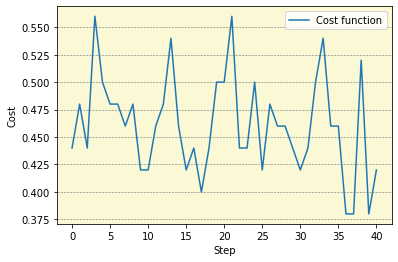

<Figure size 432x288 with 0 Axes>

In [3]:
neuron = QPerceptron(n=8)

X_train = train_df['input'].to_numpy()
y_train = train_df['label'].to_numpy()

neuron.fit(X_train, y_train, niter=20)

plot_costs(neuron.cost_array)

In [7]:
import pickle

with open('best_weights.pkl', 'wb') as f:
    pickle.dump(neuron.phi, f)

In [2]:
import pandas as pd

neuron = QPerceptron(n=8)
weights = pd.read_pickle('best_weights.pkl')
neuron.set_weights(weights)

test_df = test_df.sample(10)
X_test = test_df['input'].to_numpy()
y_test = test_df['label'].to_numpy()

pred = neuron.predict(X_test)

acc = 0
for i in range(len(pred)):
    print('Resp: {} | Pred: {} | Label: {}'.format(pred[i][1], pred[i][0], y_test[i]))
    acc += np.sum(pred[i][0] == y_test[i])

acc /= len(pred)
print('Accuracy: {} %'.format(acc * 100))

Resp: 0.6 | Pred: 1 | Label: 0
Resp: 0.9 | Pred: 1 | Label: 1
Resp: 0.9 | Pred: 1 | Label: 1
Resp: 0.7 | Pred: 1 | Label: 0
Resp: 0.9 | Pred: 1 | Label: 1
Resp: 0.9 | Pred: 1 | Label: 0
Resp: 0.4 | Pred: 0 | Label: 0
Resp: 1.0 | Pred: 1 | Label: 1
Resp: 0.6 | Pred: 1 | Label: 1
Resp: 0.9 | Pred: 1 | Label: 0
Accuracy: 60.0 %


In [3]:
pred = neuron.predict(X_test, threshold=0.7)

acc = 0
for i in range(len(pred)):
    print('Resp: {} | Pred: {} | Label: {}'.format(pred[i][1], pred[i][0], y_test[i]))
    acc += np.sum(pred[i][0] == y_test[i])

acc /= len(pred)
print('Accuracy: {} %'.format(acc * 100))

Resp: 0.5 | Pred: 0 | Label: 0
Resp: 0.6 | Pred: 0 | Label: 1
Resp: 0.8 | Pred: 1 | Label: 1
Resp: 0.7 | Pred: 0 | Label: 0
Resp: 0.6 | Pred: 0 | Label: 1
Resp: 0.5 | Pred: 0 | Label: 0
Resp: 0.7 | Pred: 0 | Label: 0
Resp: 0.7 | Pred: 0 | Label: 1
Resp: 0.8 | Pred: 1 | Label: 1
Resp: 0.9 | Pred: 1 | Label: 0
Accuracy: 60.0 %
